In [9]:
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss, yolo_head
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss, yolo_head
from yolo3.utils import get_random_data

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense, GlobalAveragePooling2D,Dropout,Conv2D
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
from keras.applications.densenet import DenseNet121
from keras.applications.resnet50 import ResNet50

from keras.models import Model
import keras.backend as K
import pandas as pd
import cv2
import os
%matplotlib inline


import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense, GlobalAveragePooling2D,Dropout,Conv2D
from keras.applications.densenet import DenseNet169, DenseNet121, DenseNet201
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
import keras.backend as K
from sklearn.metrics import roc_auc_score, cohen_kappa_score
import cv2
import os
import random
from sklearn.utils import shuffle
from keras.applications.mobilenetv2 import MobileNetV2
from keras.callbacks import Callback,ModelCheckpoint
import pydicom
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import binary_crossentropy
from keras.utils import Sequence
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tqdm import tqdm
import csv
import math
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
%matplotlib inline

In [2]:
model = yolo_body(Input(shape=(None, None, 3)), 3, 1)

In [3]:
model.load_weights('./logs/000/trained_weights_final_2.h5')

ValueError: You are trying to load a weight file containing 24 layers into a model with 147 layers.

In [7]:
model = tiny_yolo_body(Input(shape=(None, None, 3)), 3, 1)

In [11]:
model.load_weights('./logs/000/trained_weights_final_2.h5')

In [12]:
X_granuloma=np.load('X_granuloma.npy')

In [13]:
y=model.predict(X_granuloma, verbose=1)

198/198 [==============================] - 2s 11ms/step


In [23]:
y[1].shape

(198, 14, 14, 18)

In [84]:
# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

class YOLO(object):
    _defaults = {
        "model_path": './logs/000/trained_weights_final_2.h5',
        "anchors_path": 'model_data/tiny_yolo_anchors.txt',
        "classes_path": 'model_data/granuloma.txt',
        "score" : 0.001,
        "iou" : 0.001,
        "model_image_size" : (224, 224),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        print (class_names)
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            #self.yolo_model = load_model(model_path, compile=False)
            self.yolo_model = tiny_yolo_body(Input(shape=(None, None, 3)), 3, 1)
            self.yolo_model.load_weights('./logs/000/trained_weights_final_2.h5')
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
        if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })
        print(out_boxes, out_scores, out_classes) 
        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()



In [85]:
a=YOLO()

['granuloma']
./logs/000/trained_weights_final_2.h5 model, anchors, and classes loaded.


(224, 224, 3)
[[ -8.099115  198.54596    44.673447  225.87991  ]
 [128.75777   161.93219   175.08752   176.13794  ]
 [120.21258    81.66399   174.71753   117.70165  ]
 [160.90054    55.86212   196.55493    79.14613  ]
 [  1.6289241  42.315037   36.26242    60.507153 ]
 [180.55122   141.6146    211.58      186.14307  ]
 [196.23946    15.702008  228.75998    58.759975 ]
 [ 32.21584   125.194626   80.99817   148.03036  ]
 [ -3.771132   -6.3871465  19.457602   18.479418 ]
 [ -3.1885867 173.77617    20.592804  192.04718  ]
 [ 21.530268  169.01514    49.70298   192.61667  ]
 [136.6088    195.90712   189.09619   229.28482  ]
 [154.9776     -2.5337634 184.11536    15.916241 ]
 [ 87.59738   142.7163    123.42121   161.99086  ]
 [ 34.53362    62.9849     76.95024    84.19827  ]
 [198.0285    198.96164   230.23035   230.63385  ]
 [-15.972657  140.39017    26.504406  160.76144  ]
 [ 38.508137   98.194405   74.093895  112.89377  ]
 [ -8.635679   72.95331    19.818954   98.3288   ]
 [ 89.17074    -2

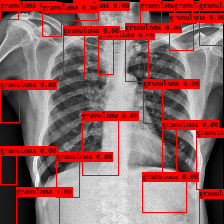

In [86]:
from PIL import Image
from matplotlib import cm
im = Image.fromarray(X_granuloma[50])

a.detect_image(im)

In [27]:
plt.imsave("first_granuloma.png", X_granuloma[0])

In [43]:
new_image=detect_image(im)

NameError: name 'detect_image' is not defined

In [42]:
X_granuloma[0].size

150528